In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from optuna import Study, Trial
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna

from model.wrapper import RoundingWrapper
from model.scoring import cross_val_splits, kicktipp_scoring
from model.simple_models import StaticEstimator
from model.simple_models import LatestTableEstimator
from model.plots import cross_val_plot

/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEBUG = False

In [3]:
df_matches = pd.read_csv("./data/matches.csv")

## Static Results

2:1:	359.692 +- 22.331
1:0:	354.462 +- 25.954
2:0:	340.615 +- 20.239
3:1:	334.923 +- 18.833
1:2:	248.000 +- 20.305
0:1:	245.769 +- 20.826
1:1:	223.385 +- 17.014
0:0:	187.692 +- 17.451
2:2:	183.538 +- 15.255


(0.0, 13.0)

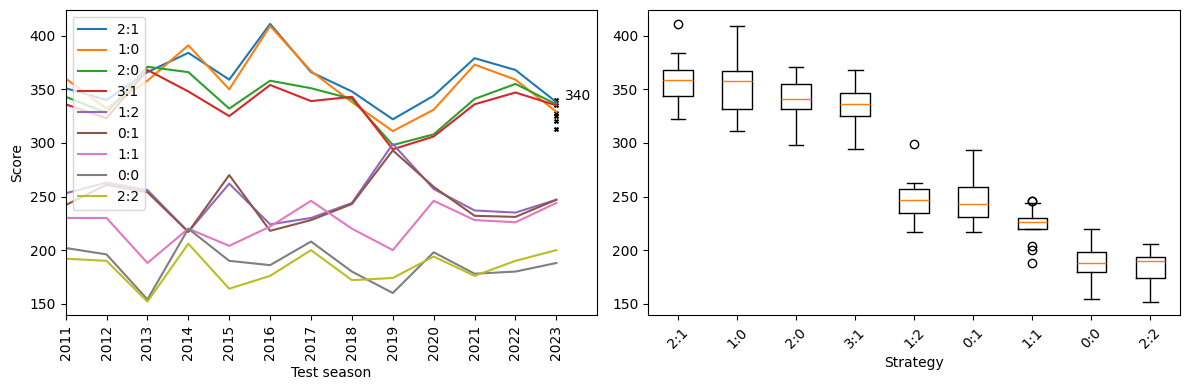

In [4]:

splits = cross_val_splits(df_matches)
y_train = df_matches[["host_goals", "guest_goals"]].values

static_results = [
    [0, 0],
    [1, 0], 
    [0, 1],
    [1, 1],
    [2, 0], 
    [2, 1],
    [1, 2],
    [2, 2],
    [3, 1]
]

models = [StaticEstimator(result) for result in static_results]
labels = [f"{r[0]}:{r[1]}" for r in static_results]
scores = [cross_val_score(model, df_matches, y_train, cv=splits, scoring=kicktipp_scoring) for model in models]

fig, axs = cross_val_plot(df_matches, splits, labels, scores)
real_results = [340, 335, 328, 325, 320, 313]
axs[0].scatter([12] * len(real_results), real_results, s=8, marker="x", color="black")
axs[0].text(12.2, 340, max(real_results))
axs[0].set_xlim(0, 13)


## Based on table 

Table-based:	375.308 +- 26.034
2:1:	359.692 +- 22.331


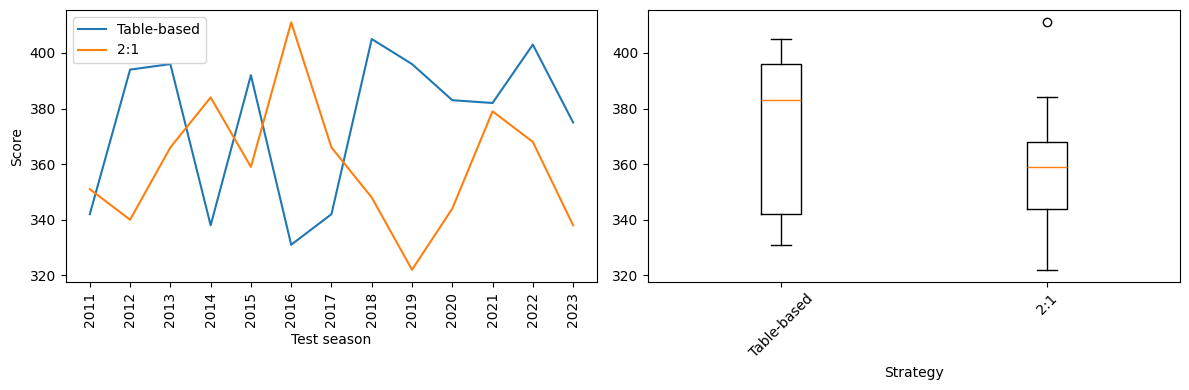

In [5]:

models = [StaticEstimator([2, 1]), LatestTableEstimator()]
labels = ["2:1", "Table-based"]
scores = [cross_val_score(model, df_matches, y_train, cv=splits, scoring=kicktipp_scoring) for model in models]

fig, axs = cross_val_plot(df_matches, splits, labels, scores)

# Matches with team context

In [6]:
df_matches = df_matches.fillna(0)
df_matches.tail()

,id,match_day,season,host_id,host_name,guest_id,guest_name,host_goals,guest_goals,host_last_season_draws,...,diff_last_season_opponent_goals,diff_last_season_points,diff_last_season_wins,diff_horizon_points,diff_horizon_goals,diff_horizon_opponent_goals,diff_horizon_goal_diff,diff_horizon_wins,diff_horizon_draws,diff_horizon_defeats
4279,66932,34,2023,131,Wolfsburg,81,Mainz,1.0,3.0,10.0,...,-7.0,3.0,1.0,7.000000,6.000000,-5.666667,11.666667,2.333333,0.000000,-2.333333
4280,66933,34,2023,175,Hoffenheim,40,Bayern,4.0,2.0,6.0,...,19.0,-35.0,-11.0,-33.666667,-43.333333,17.333333,-60.666667,-11.666667,1.333333,10.333333
4281,66934,34,2023,134,Bremen,129,Bochum,4.0,1.0,6.0,...,-8.0,1.0,0.0,-5.000000,4.500000,-1.500000,6.000000,-2.500000,2.500000,0.000000
4282,66935,34,2023,16,Stuttgart,87,Gladbach,4.0,0.0,12.0,...,2.0,-10.0,-4.0,-8.666667,-9.333333,-0.333333,-9.000000,-3.333333,1.333333,2.000000
4283,66936,34,2023,199,Heidenheim,65,Köln,4.0,1.0,0.0,...,-54.0,-42.0,-10.0,-42.333333,-45.000000,-54.333333,-90.666667,-10.666667,-10.333333,-13.000000


In [7]:
X_all = df_matches.drop(columns=["host_name", "guest_name", "host_goals", "guest_goals"])
y_all = df_matches[["host_goals", "guest_goals"]].values
print(X_all.columns)
features = [
    "season",
    "host_id",
    "guest_id",
    "diff_last_season_goal_diff",
    "diff_last_season_points",
    "diff_horizon_points",
    "diff_horizon_goals"
]
X_all = X_all[features]

Index(['id', 'match_day', 'season', 'host_id', 'guest_id',
       'host_last_season_draws', 'host_last_season_goal_diff',
       'host_last_season_goals', 'host_last_season_defeats',
       'host_last_season_matches', 'host_last_season_opponent_goals',
       'host_last_season_points', 'host_last_season_wins',
       'guest_last_season_draws', 'guest_last_season_goal_diff',
       'guest_last_season_goals', 'guest_last_season_defeats',
       'guest_last_season_matches', 'guest_last_season_opponent_goals',
       'guest_last_season_points', 'guest_last_season_wins',
       'host_horizon_points', 'host_horizon_goals',
       'host_horizon_opponent_goals', 'host_horizon_goal_diff',
       'host_horizon_wins', 'host_horizon_draws', 'host_horizon_defeats',
       'guest_horizon_points', 'guest_horizon_goals',
       'guest_horizon_opponent_goals', 'guest_horizon_goal_diff',
       'guest_horizon_wins', 'guest_horizon_draws', 'guest_horizon_defeats',
       'diff_last_season_draws', 'diff_l

## Random Forest

In [8]:
splits = cross_val_splits(X_all, start=3)

def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 10, 75)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    estimator = RoundingWrapper(RandomForestRegressor(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=4
    ))
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf", load_if_exists=True)
rf_study.optimize(objective, n_trials=2 if DEBUG else 100)
print(rf_study.best_value, rf_study.best_params)

[I 2024-09-09 19:29:02,619] Using an existing study with name 'rf' instead of creating a new one.
[I 2024-09-09 19:29:03,626] Trial 243 finished with value: 384.45454545454544 and parameters: {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 48, 'min_samples_split': 66}. Best is trial 61 with value: 388.90909090909093.
[I 2024-09-09 19:29:04,543] Trial 244 finished with value: 386.90909090909093 and parameters: {'criterion': 'poisson', 'max_depth': 4, 'n_estimators': 48, 'min_samples_split': 68}. Best is trial 61 with value: 388.90909090909093.
[I 2024-09-09 19:29:05,578] Trial 245 finished with value: 386.1818181818182 and parameters: {'criterion': 'poisson', 'max_depth': 4, 'n_estimators': 46, 'min_samples_split': 69}. Best is trial 61 with value: 388.90909090909093.
[I 2024-09-09 19:29:06,542] Trial 246 finished with value: 384.90909090909093 and parameters: {'criterion': 'poisson', 'max_depth': 4, 'n_estimators': 48, 'min_samples_split': 72}. Best is trial 61 with value: 388

390.1818181818182 {'criterion': 'poisson', 'max_depth': 3, 'n_estimators': 57, 'min_samples_split': 74}


In [9]:
def build_rf_model(study):
    best_params = study.best_params
    return RoundingWrapper(RandomForestRegressor(
        n_estimators=best_params['n_estimators'], 
        criterion=best_params['criterion'], 
        max_depth=best_params['max_depth'], 
        min_samples_split=best_params['min_samples_split'],
        n_jobs=4
    ))
    

## Gradient Boosting

In [10]:
def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 25, 75)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = RoundingWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ))
    elif algo == "lgbm":
        estimator = RoundingWrapper(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        )))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb", load_if_exists=True)
gb_study.optimize(objective, n_trials=2 if DEBUG else 200)
print(gb_study.best_value, gb_study.best_params)

[I 2024-09-09 19:31:21,873] Using an existing study with name 'gb' instead of creating a new one.


[I 2024-09-09 19:31:22,282] Trial 600 finished with value: 387.0 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 3, 'lambda': 0.9397478909473598, 'alpha': 1.796581287949675, 'learning_rate': 0.15594691727947982, 'num_leaves': 2, 'min_child_weight': 7.356664164224142, 'objective-lgbm': 'poisson'}. Best is trial 600 with value: 387.0.
[I 2024-09-09 19:31:22,546] Trial 601 finished with value: 382.45454545454544 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 7, 'lambda': 0.9495868851984621, 'alpha': 1.7129442864963336, 'learning_rate': 0.15557853624482496, 'num_leaves': 4, 'min_child_weight': 6.389822407436127, 'objective-lgbm': 'poisson'}. Best is trial 600 with value: 387.0.
[I 2024-09-09 19:31:22,742] Trial 602 finished with value: 384.8181818181818 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 3, 'lambda': 0.9822112824313896, 'alpha': 1.8056874080692804, 'learning_rate': 0.1430850298088697, 'num_leaves': 2, 'min_child_weight': 7

387.0 {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 3, 'lambda': 0.9397478909473598, 'alpha': 1.796581287949675, 'learning_rate': 0.15594691727947982, 'num_leaves': 2, 'min_child_weight': 7.356664164224142, 'objective-lgbm': 'poisson'}


In [11]:
def build_gb_model(study):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda=params["lambda"]
    reg_alpha=params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves=params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    if algo == "xgb":
        estimator = RoundingWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-xgb"],
        ))
    elif algo == "lgbm":
        estimator = RoundingWrapper(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-lgbm"],
        )))
    return estimator
    

## SVR

In [12]:
def objective(trial: Trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 4)
    else:
        degree = 3
    estimator = RoundingWrapper(MultiOutputRegressor(SVR(
        kernel=kernel,
        degree=degree,
        C=trial.suggest_float("C", 0.0, 3.0)
    )))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

svr_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="svr", load_if_exists=True)
svr_study.optimize(objective, n_trials=2 if DEBUG else 10)
print(svr_study.best_value, svr_study.best_params)


[I 2024-09-09 19:32:12,103] Using an existing study with name 'svr' instead of creating a new one.
[I 2024-09-09 19:32:15,768] Trial 21 finished with value: 301.45454545454544 and parameters: {'kernel': 'poly', 'degree': 2, 'C': 1.6999714374494115}. Best is trial 1 with value: 358.3636363636364.
[I 2024-09-09 19:32:22,453] Trial 22 finished with value: 329.8181818181818 and parameters: {'kernel': 'linear', 'C': 2.519063412266959}. Best is trial 1 with value: 358.3636363636364.
[I 2024-09-09 19:32:28,950] Trial 23 finished with value: 329.8181818181818 and parameters: {'kernel': 'linear', 'C': 2.2615505583002085}. Best is trial 1 with value: 358.3636363636364.
[I 2024-09-09 19:32:36,259] Trial 24 finished with value: 329.09090909090907 and parameters: {'kernel': 'linear', 'C': 2.9416267243832954}. Best is trial 1 with value: 358.3636363636364.
[I 2024-09-09 19:32:43,132] Trial 25 finished with value: 329.8181818181818 and parameters: {'kernel': 'linear', 'C': 2.6689707839201153}. Best i

358.3636363636364 {'kernel': 'linear', 'C': 2.9824438424486712}


In [13]:
def build_svr_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(MultiOutputRegressor(SVR(
        kernel=params["kernel"],
        degree=params["degree"] if "degree" in params else 3,
        C=params["C"]
    )))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

## KNN Regressor

In [14]:
def objective(trial: Trial):
    estimator = RoundingWrapper(KNeighborsRegressor(
        n_neighbors=trial.suggest_int("n_neighbors", 5, 100),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric=trial.suggest_categorical("metric", ["cityblock", "cosine", "euclidean", "l1"])
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

knn_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="knn", load_if_exists=True)
knn_study.optimize(objective, n_trials=20 if DEBUG else 200)
print(knn_study.best_value, knn_study.best_params)

def build_knn_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(KNeighborsRegressor(
        n_neighbors=params["n_neighbors"],
        weights=params["weights"],
        metric=params["metric"]
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-09 19:35:16,734] Using an existing study with name 'knn' instead of creating a new one.
[I 2024-09-09 19:35:17,050] Trial 400 finished with value: 372.54545454545456 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 245 with value: 375.54545454545456.
[I 2024-09-09 19:35:17,235] Trial 401 finished with value: 372.90909090909093 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 245 with value: 375.54545454545456.
[I 2024-09-09 19:35:17,417] Trial 402 finished with value: 372.72727272727275 and parameters: {'n_neighbors': 96, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 245 with value: 375.54545454545456.
[I 2024-09-09 19:35:17,599] Trial 403 finished with value: 371.0 and parameters: {'n_neighbors': 93, 'weights': 'distance', 'metric': 'cityblock'}. Best is trial 245 with value: 375.54545454545456.
[I 2024-09-09 19:35:17,787] Trial 404 finished with value: 372.545454

375.54545454545456 {'n_neighbors': 96, 'weights': 'uniform', 'metric': 'l1'}


## MLP

In [15]:
def objective(trial: Trial):
    size_1 = trial.suggest_int("size_1", 4, 30)
    size_2 = trial.suggest_int("size_2", 4, 20)
    estimator = RoundingWrapper(MLPRegressor(
        hidden_layer_sizes=(size_1, size_2),
        learning_rate_init=trial.suggest_float("learning_rate_init", 0.0001, 0.01),
        max_iter=500
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

mlp_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="mlp", load_if_exists=True)
mlp_study.optimize(objective, n_trials=2 if DEBUG else 20)
print(mlp_study.best_value, mlp_study.best_params)

def build_mlp_model(study: Study):
    params = study.best_params
    estimator = RoundingWrapper(MLPRegressor(
        hidden_layer_sizes=(params["size_1"], params["size_2"]),
        learning_rate_init=params["learning_rate_init"]
    ))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-09 19:35:54,479] Using an existing study with name 'mlp' instead of creating a new one.
[I 2024-09-09 19:35:56,907] Trial 50 finished with value: 341.72727272727275 and parameters: {'size_1': 9, 'size_2': 11, 'learning_rate_init': 0.006493012461060947}. Best is trial 30 with value: 374.09090909090907.
[I 2024-09-09 19:35:59,680] Trial 51 finished with value: 363.1818181818182 and parameters: {'size_1': 5, 'size_2': 13, 'learning_rate_init': 0.004323762094507608}. Best is trial 30 with value: 374.09090909090907.
[I 2024-09-09 19:36:01,478] Trial 52 finished with value: 366.54545454545456 and parameters: {'size_1': 4, 'size_2': 14, 'learning_rate_init': 0.004962938716511105}. Best is trial 30 with value: 374.09090909090907.
[I 2024-09-09 19:36:03,102] Trial 53 finished with value: 364.1818181818182 and parameters: {'size_1': 4, 'size_2': 12, 'learning_rate_init': 0.006036186792058891}. Best is trial 30 with value: 374.09090909090907.
[I 2024-09-09 19:36:05,589] Trial 54 finish

374.09090909090907 {'size_1': 4, 'size_2': 20, 'learning_rate_init': 0.009362576622035147}


rf:	387.364 +- 13.740
gb:	387.000 +- 18.882
mlp:	382.455 +- 18.695
knn:	374.545 +- 16.588
svr:	329.455 +- 29.190


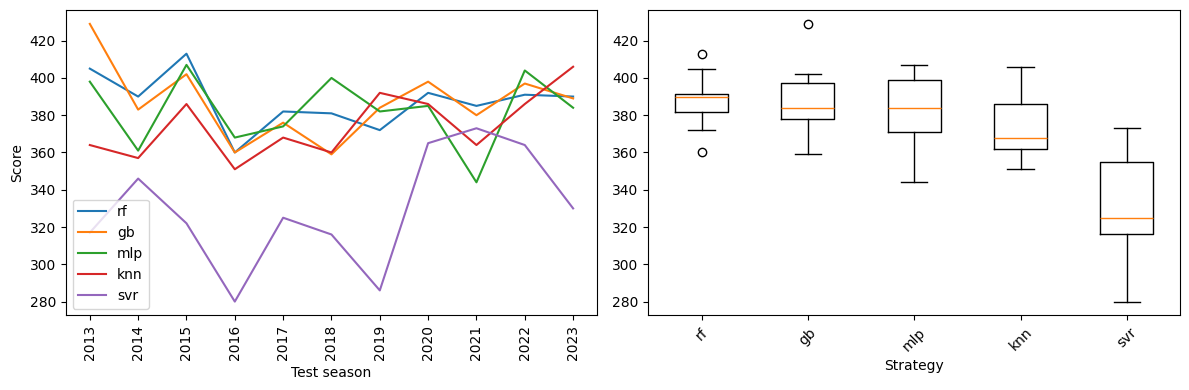

In [16]:

models = {
    #"table-based": LatestTableEstimator(),
    "rf": build_rf_model(rf_study),
    "gb": build_gb_model(gb_study),
    "svr": build_svr_model(svr_study),
    "knn": build_knn_model(knn_study),
    "mlp": build_mlp_model(mlp_study)
}

labels = list(models.keys())
scores = [cross_val_score(models[name], X_all, y_all, cv=splits, scoring=kicktipp_scoring) for name in models.keys()]

fig, axs = cross_val_plot(df_matches, splits, labels, scores)


In [17]:
model = build_gb_model(gb_study)
train_idx, test_idx = splits[-2]
X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred_raw = model.regressor.predict(X_train)

df_full_train = df_matches.iloc[train_idx].copy()
df_full_train["team1Goals_pred"] = y_train_pred[:, 0]
df_full_train["team2Goals_pred"] = y_train_pred[:, 1]
df_full_train["team1Goals_pred_raw"] = y_train_pred_raw[:, 0]
df_full_train["team2Goals_pred_raw"] = y_train_pred_raw[:, 1]
df_full_train[["season", "match_day", "host_name", "guest_name", "host_goals", "guest_goals", "team1Goals_pred", "team2Goals_pred"]]

,season,match_day,host_name,guest_name,host_goals,guest_goals,team1Goals_pred,team2Goals_pred
0,2010,1,Bayern,Wolfsburg,2.0,1.0,2.0,1.0
1,2010,1,Hoffenheim,Bremen,4.0,1.0,2.0,1.0
2,2010,1,Gladbach,Nürnberg,1.0,1.0,2.0,1.0
3,2010,1,Köln,Kaiserslautern,1.0,3.0,2.0,1.0
4,2010,1,Freiburg,St. Pauli,1.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...
3667,2021,34,Gladbach,Hoffenheim,5.0,1.0,2.0,1.0
3668,2021,34,Mainz,Frankfurt,2.0,2.0,1.0,1.0
3669,2021,34,Stuttgart,Köln,2.0,1.0,2.0,1.0
3670,2021,34,Union Berlin,Bochum,3.0,2.0,2.0,1.0


<Axes: >

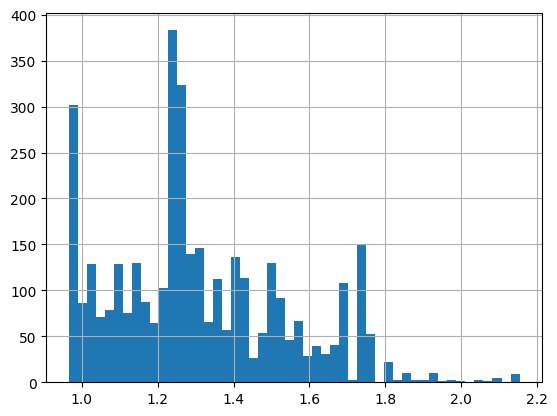

In [18]:
df_full_train["team2Goals_pred_raw"].hist(bins=50)

In [19]:
df_full_train[["team1Goals_pred", "team2Goals_pred"]].value_counts()

team1Goals_pred  team2Goals_pred
2.0              1.0                2536
1.0              2.0                 712
                 1.0                 350
2.0              2.0                  39
3.0              1.0                  35
Name: count, dtype: int64

# Difference Regression

## KNN Diff

In [20]:
from model.wrapper import DifferenceWrapper


def objective(trial: Trial):
    estimator = DifferenceWrapper(KNeighborsRegressor(
        n_neighbors=trial.suggest_int("n_neighbors", 5, 50),
        weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric=trial.suggest_categorical("metric", ["cityblock", "cosine", "euclidean", "l1"]),
    ), base=trial.suggest_float("base", 0.0, 2.0))
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    scores = cross_val_score(pipeline, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

knn_diff_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="knn_diff", load_if_exists=True)
knn_diff_study.optimize(objective, n_trials=20 if DEBUG else 100)
print(knn_diff_study.best_value, knn_diff_study.best_params)

def build_knn_model(study: Study):
    params = study.best_params
    estimator = DifferenceWrapper(KNeighborsRegressor(
        n_neighbors=params["n_neighbors"],
        weights=params["weights"],
        metric=params["metric"]
    ), base=params["base"])
    pipeline = make_pipeline(
        preprocessing.StandardScaler(),
        estimator
    )
    return pipeline

[I 2024-09-09 19:36:46,233] Using an existing study with name 'knn_diff' instead of creating a new one.
[I 2024-09-09 19:36:46,406] Trial 100 finished with value: 346.09090909090907 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'metric': 'cityblock', 'base': 1.2896243687717222}. Best is trial 32 with value: 367.6363636363636.
[I 2024-09-09 19:36:46,561] Trial 101 finished with value: 355.6363636363636 and parameters: {'n_neighbors': 44, 'weights': 'uniform', 'metric': 'cityblock', 'base': 1.4505846815002412}. Best is trial 32 with value: 367.6363636363636.
[I 2024-09-09 19:36:46,712] Trial 102 finished with value: 349.6363636363636 and parameters: {'n_neighbors': 45, 'weights': 'uniform', 'metric': 'cityblock', 'base': 1.3946605214346004}. Best is trial 32 with value: 367.6363636363636.
[I 2024-09-09 19:36:46,882] Trial 103 finished with value: 312.6363636363636 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'metric': 'cityblock', 'base': 1.598554310844753}. Best

367.6363636363636 {'n_neighbors': 34, 'weights': 'distance', 'metric': 'euclidean', 'base': 1.493868816683987}


## GB Diff

In [24]:

def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 50, 50)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = DifferenceWrapper(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ), base=trial.suggest_float("basee", 0.0, 2.0))
    elif algo == "lgbm":
        estimator = DifferenceWrapper(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        ), base=trial.suggest_float("basee", 0.0, 2.0))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_diff_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb_diff", load_if_exists=True)
gb_diff_study.optimize(objective, n_trials=2 if DEBUG else 200)
print(gb_diff_study.best_value, gb_diff_study.best_params)

[I 2024-09-09 19:38:35,927] Using an existing study with name 'gb_diff' instead of creating a new one.
[I 2024-09-09 19:38:36,476] Trial 402 finished with value: 316.1818181818182 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 8, 'lambda': 1.8198302719377253, 'alpha': 1.9852086249607674, 'learning_rate': 0.24301349022515645, 'num_leaves': 21, 'min_child_weight': 2.632589444387164, 'objective-xgb': 'reg:squarederror', 'basee': 0.4170093768333061}. Best is trial 217 with value: 364.45454545454544.
[I 2024-09-09 19:38:36,858] Trial 403 finished with value: 310.6363636363636 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 8, 'lambda': 1.8830093546715554, 'alpha': 1.9331647706520978, 'learning_rate': 0.16407053040452232, 'num_leaves': 23, 'min_child_weight': 2.1530705218359767, 'objective-xgb': 'reg:squarederror', 'basee': 1.6631775124319097}. Best is trial 217 with value: 364.45454545454544.
[I 2024-09-09 19:38:37,246] Trial 404 finished with value: 295.6

369.3636363636364 {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 14, 'lambda': 0.30467213287812, 'alpha': 0.4664597446243198, 'learning_rate': 0.0940921741432195, 'num_leaves': 8, 'min_child_weight': 9.271119330039069, 'objective-lgbm': 'rmse', 'basee': 1.4301002746497384}
